#Introduction

Trying to implement attention -> fist attempt quite good, strange peaks


### Some othe attempts done to try to improve the performances, here the more relevant, the notebook refers to the last one

Step 1) Increased window from 250 to 450

Step 2) Changed stride to 10

Step 3) Changed window to 250

Step 4) Added some CNN layers + parallel network

Step 5) Changed window to 800 - batch to 32

# Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
%cd /gdrive/MyDrive/Challenge2_Mio

/gdrive/MyDrive/Challenge2_Mio


In [ ]:
!pip install keras-self-attention

  Created wheel for keras-self-attention: filename=keras_self_attention-0.50.0-py3-none-any.whl size=19414 sha256=8a212d04fa0aa571128caa4efad991453bdb997f0d0e6632ddeeb9dd7a828493
  Stored in directory: /root/.cache/pip/wheels/92/7a/a3/231bef5803298e7ec1815215bc0613239cb1e9c03c57b13c14
Successfully built keras-self-attention


# Import libraries

In [ ]:
title = 'Attention_v10' #used to save models and checkpoint. Assumes in the current folder, you have a folder called "Models"

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
import warnings
from keras_self_attention import SeqSelfAttention, SeqWeightedAttention

warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


### Set seed for reproducibility

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Exploration Data Analysis (EDA)


Load the dataset

In [ ]:
dataset = pd.read_csv('Training.csv')
print(dataset.shape)
dataset.head()

(68528, 7)


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,7.97698,4.33494,10.67282,1.76692,3.22440,51.681460,3.65434
1,8.07824,4.44616,10.56160,1.70716,3.32566,51.563598,3.47672
2,8.02844,4.22372,10.56160,1.64906,3.17460,50.863080,3.47672
3,8.02844,4.22372,10.56160,1.70716,3.17460,45.841581,3.47672
4,7.87572,4.44616,10.45038,1.70716,3.27586,47.126421,3.47672


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68528 entries, 0 to 68527
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sponginess          68528 non-null  float64
 1   Wonder level        68528 non-null  float64
 2   Crunchiness         68528 non-null  float64
 3   Loudness on impact  68528 non-null  float64
 4   Meme creativity     68528 non-null  float64
 5   Soap slipperiness   68528 non-null  float64
 6   Hype root           68528 non-null  float64
dtypes: float64(7)
memory usage: 3.7 MB


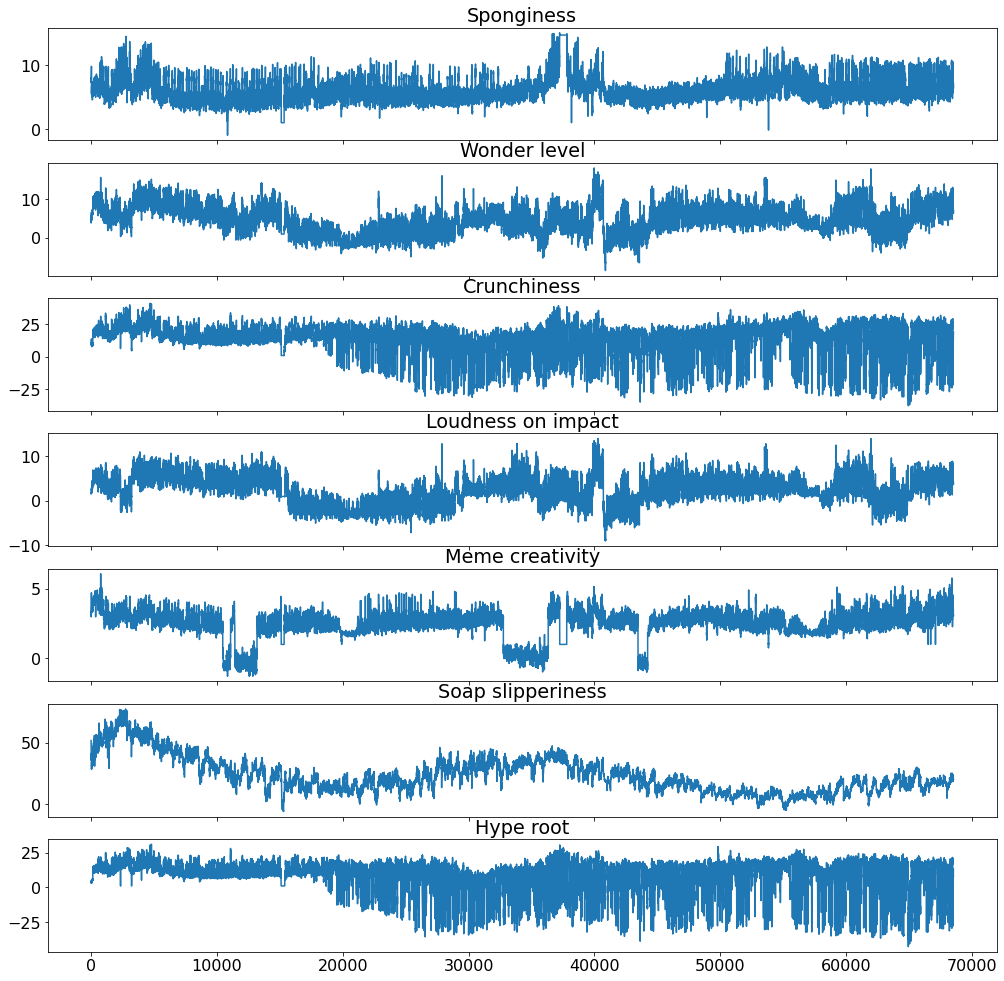

In [ ]:
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()
inspect_dataframe(dataset, dataset.columns)

Sequential Train-Test split and normalization

In [ ]:
print((dataset.shape))

(68528, 7)


(63528, 7) (5000, 7)


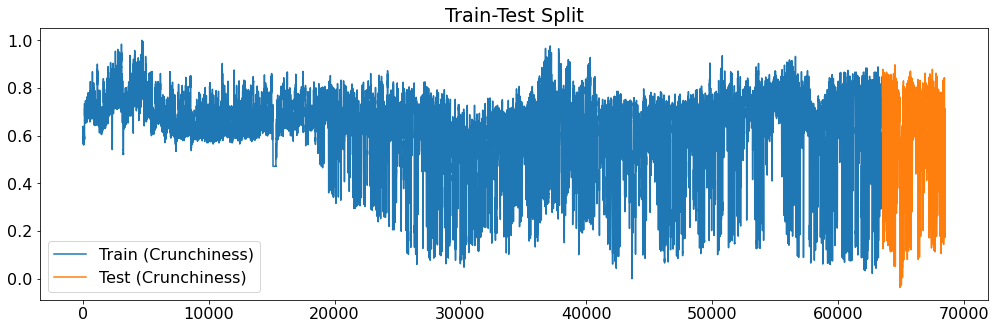

In [ ]:
test_size = 5000
X_train_raw = dataset.iloc[:-test_size]
# y_train_raw = y.iloc[:-test_size]
X_test_raw = dataset.iloc[-test_size:]

# y_test_raw = y.iloc[-test_size:]
print(X_train_raw.shape, X_test_raw.shape)

# Normalize both features and labels
X_min = X_train_raw.min()
X_max = X_train_raw.max()

X_train_raw = (X_train_raw-X_min)/(X_max-X_min)
X_test_raw = (X_test_raw-X_min)/(X_max-X_min)

plt.figure(figsize=(17,5))
plt.plot(X_train_raw.Crunchiness, label='Train (Crunchiness)')
plt.plot(X_test_raw.Crunchiness, label='Test (Crunchiness)')
plt.title('Train-Test Split')
plt.legend()
plt.show()

In [ ]:
print('X_min')
print(X_min)
print('X_max')
print(X_max)
print(X_max - X_min)

X_min
Sponginess            -0.972080
Wonder level          -8.450380
Crunchiness          -34.802881
Loudness on impact    -9.028060
Meme creativity       -1.275860
Soap slipperiness     -6.006860
Hype root            -38.816760
dtype: float64
X_max
Sponginess            15.106680
Wonder level          18.122899
Crunchiness           41.138801
Loudness on impact    14.035980
Meme creativity        6.056360
Soap slipperiness     77.371620
Hype root             31.024420
dtype: float64
Sponginess            16.078760
Wonder level          26.573279
Crunchiness           75.941682
Loudness on impact    23.064040
Meme creativity        7.332220
Soap slipperiness     83.378480
Hype root             69.841180
dtype: float64


In [ ]:
ar_window = 800
ar_stride = 10
general_telescope = 864

In [ ]:
def build_sequences(df, target_labels=['Sponginess'], window=200, stride=20, telescope=864):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

# Utility functions

In [ ]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('Check')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback  = tfk.callbacks.EarlyStopping(monitor='val_rmse', mode='min', patience=30, restore_best_weights=True),
  callbacks.append(es_callback)
  es2_callback = tfk.callbacks.ReduceLROnPlateau(monitor='val_rmse', mode='min', patience=5, factor=0.5, min_lr=1e-5)
  callbacks.append(es2_callback)

  return callbacks

In [ ]:
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

In [ ]:
def build_LSTM_model(input_shape, output_shape):
    # We build a network with diffrent branches
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Left part
    lstm = tfkl.Bidirectional(tfkl.LSTM(256, return_sequences=True))(input_layer)
    attention1 = SeqSelfAttention(attention_activation='sigmoid')(lstm)

    # Right part
    cnn_a = tfkl.Conv1D(64,7,padding='same',activation='relu')(input_layer)
    cnn_a = tfkl.Dropout(0.3)(cnn_a)
    attention2 = SeqSelfAttention(attention_activation='sigmoid')(cnn_a)

    cnn_b = tfkl.Conv1D(64,5,padding='same',activation='relu')(input_layer)
    cnn_b = tfkl.Dropout(0.3)(cnn_b)
    attention3 = SeqSelfAttention(attention_activation='sigmoid')(cnn_b)

    merged = tfkl.concatenate([attention1, attention2, attention3], axis=2)
    merged = tfkl.GlobalAveragePooling1D()(merged)

    dense = tfkl.Dense(output_shape[0]*output_shape[1], activation='relu')(merged)
    output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(dense)
    # Connect input and output through the Model class
    full_model = tfk.Model(inputs=input_layer, outputs=output_layer)
    # Compile the model
    full_model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')])

    # Return the model
    return full_model

In [ ]:
target_labels = dataset.columns
telescope = 864

In [ ]:
X_train, y_train = build_sequences(X_train_raw, target_labels, ar_window, ar_stride, telescope)
X_test, y_test = build_sequences(X_test_raw, target_labels, ar_window, ar_stride, telescope)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6234, 800, 7), (6234, 864, 7), (394, 800, 7), (394, 864, 7))

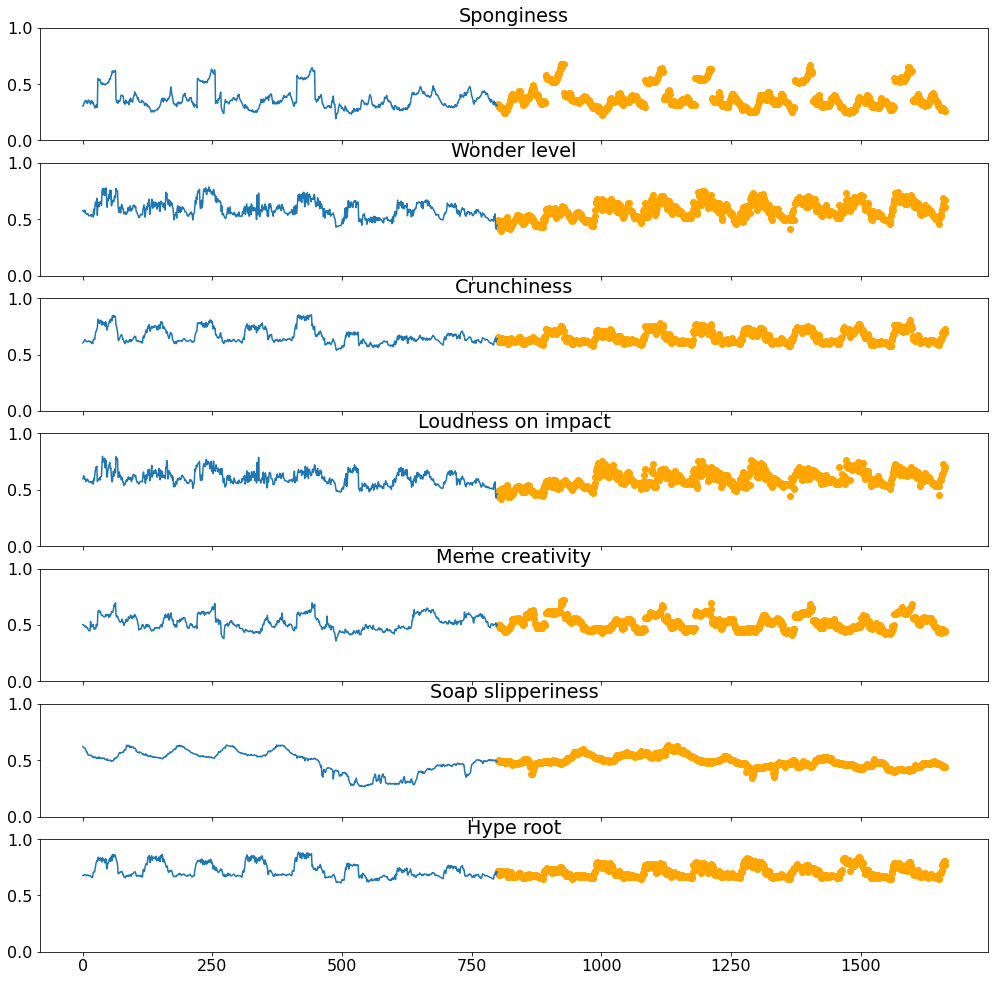

In [ ]:
inspect_multivariate(X_train, y_train, target_labels, telescope)

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 16
epochs = 500

In [ ]:
print(input_shape, output_shape)

(800, 7) (864, 7)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 800, 7)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 800, 64)      3200        ['Input[0][0]']                  
                                                                                                  
 conv1d_1 (Conv1D)              (None, 800, 64)      2304        ['Input[0][0]']                  
                                                                                                  
 bidirectional (Bidirectional)  (None, 800, 512)     540672      ['Input[0][0]']                  
                                                                                              

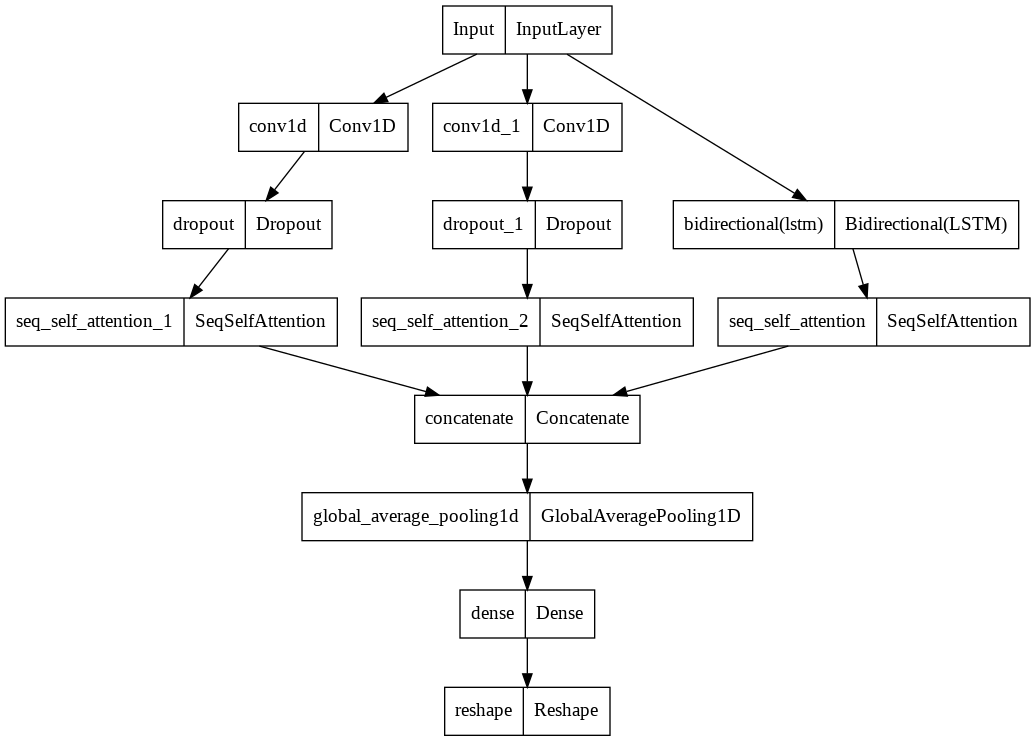

In [ ]:
model = build_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

# Training and testing

In [ ]:
# Create folders and callbacks and fit
cbs = create_folders_and_callbacks(model_name = title) #the model name will generate the folder of this single experiment

# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = cbs
).history

Epoch 1/500
351/351 [==============================] - ETA: 0s - loss: 0.0868 - mae: 0.2001 - rmse: 0.2946

351/351 [==============================] - 175s 358ms/step - loss: 0.0868 - mae: 0.2001 - rmse: 0.2946 - val_loss: 0.0745 - val_mae: 0.1811 - val_rmse: 0.2729 - lr: 0.0010
Epoch 2/500
351/351 [==============================] - ETA: 0s - loss: 0.0689 - mae: 0.1688 - rmse: 0.2625

351/351 [==============================] - 123s 351ms/step - loss: 0.0689 - mae: 0.1688 - rmse: 0.2625 - val_loss: 0.0661 - val_mae: 0.1685 - val_rmse: 0.2571 - lr: 0.0010
Epoch 3/500
351/351 [==============================] - ETA: 0s - loss: 0.0614 - mae: 0.1563 - rmse: 0.2478

351/351 [==============================] - 124s 354ms/step - loss: 0.0614 - mae: 0.1563 - rmse: 0.2478 - val_loss: 0.0586 - val_mae: 0.1605 - val_rmse: 0.2422 - lr: 0.0010
Epoch 4/500
351/351 [==============================] - ETA: 0s - loss: 0.0541 - mae: 0.1449 - rmse: 0.2326

351/351 [==============================] - 124s 353ms/step - loss: 0.0541 - mae: 0.1449 - rmse: 0.2326 - val_loss: 0.0522 - val_mae: 0.1480 - val_rmse: 0.2286 - lr: 0.0010
Epoch 5/500
351/351 [==============================] - ETA: 0s - loss: 0.0454 - mae: 0.1311 - rmse: 0.2131

351/351 [==============================] - 124s 354ms/step - loss: 0.0454 - mae: 0.1311 - rmse: 0.2131 - val_loss: 0.0451 - val_mae: 0.1365 - val_rmse: 0.2124 - lr: 0.0010
Epoch 6/500
351/351 [==============================] - ETA: 0s - loss: 0.0399 - mae: 0.1218 - rmse: 0.1998

351/351 [==============================] - 124s 352ms/step - loss: 0.0399 - mae: 0.1218 - rmse: 0.1998 - val_loss: 0.0429 - val_mae: 0.1342 - val_rmse: 0.2071 - lr: 0.0010
Epoch 7/500
351/351 [==============================] - ETA: 0s - loss: 0.0369 - mae: 0.1168 - rmse: 0.1921

351/351 [==============================] - 124s 354ms/step - loss: 0.0369 - mae: 0.1168 - rmse: 0.1921 - val_loss: 0.0405 - val_mae: 0.1298 - val_rmse: 0.2012 - lr: 0.0010
Epoch 8/500
351/351 [==============================] - ETA: 0s - loss: 0.0335 - mae: 0.1118 - rmse: 0.1831

351/351 [==============================] - 124s 354ms/step - loss: 0.0335 - mae: 0.1118 - rmse: 0.1831 - val_loss: 0.0364 - val_mae: 0.1221 - val_rmse: 0.1908 - lr: 0.0010
Epoch 9/500
351/351 [==============================] - ETA: 0s - loss: 0.0301 - mae: 0.1059 - rmse: 0.1734

351/351 [==============================] - 124s 353ms/step - loss: 0.0301 - mae: 0.1059 - rmse: 0.1734 - val_loss: 0.0355 - val_mae: 0.1236 - val_rmse: 0.1884 - lr: 0.0010
Epoch 10/500
351/351 [==============================] - ETA: 0s - loss: 0.0287 - mae: 0.1043 - rmse: 0.1694

351/351 [==============================] - 124s 354ms/step - loss: 0.0287 - mae: 0.1043 - rmse: 0.1694 - val_loss: 0.0327 - val_mae: 0.1162 - val_rmse: 0.1809 - lr: 0.0010
Epoch 11/500
351/351 [==============================] - ETA: 0s - loss: 0.0267 - mae: 0.1008 - rmse: 0.1634

351/351 [==============================] - 124s 354ms/step - loss: 0.0267 - mae: 0.1008 - rmse: 0.1634 - val_loss: 0.0318 - val_mae: 0.1146 - val_rmse: 0.1783 - lr: 0.0010
Epoch 12/500
351/351 [==============================] - ETA: 0s - loss: 0.0239 - mae: 0.0981 - rmse: 0.1545

351/351 [==============================] - 124s 354ms/step - loss: 0.0239 - mae: 0.0981 - rmse: 0.1545 - val_loss: 0.0272 - val_mae: 0.1094 - val_rmse: 0.1650 - lr: 0.0010
Epoch 13/500
351/351 [==============================] - ETA: 0s - loss: 0.0200 - mae: 0.0918 - rmse: 0.1416

351/351 [==============================] - 124s 354ms/step - loss: 0.0200 - mae: 0.0918 - rmse: 0.1416 - val_loss: 0.0233 - val_mae: 0.1024 - val_rmse: 0.1528 - lr: 0.0010
Epoch 14/500
351/351 [==============================] - ETA: 0s - loss: 0.0176 - mae: 0.0874 - rmse: 0.1326

351/351 [==============================] - 124s 354ms/step - loss: 0.0176 - mae: 0.0874 - rmse: 0.1326 - val_loss: 0.0230 - val_mae: 0.1023 - val_rmse: 0.1517 - lr: 0.0010
Epoch 15/500
351/351 [==============================] - ETA: 0s - loss: 0.0172 - mae: 0.0864 - rmse: 0.1312

351/351 [==============================] - 123s 352ms/step - loss: 0.0172 - mae: 0.0864 - rmse: 0.1312 - val_loss: 0.0227 - val_mae: 0.1028 - val_rmse: 0.1505 - lr: 0.0010
Epoch 16/500
351/351 [==============================] - ETA: 0s - loss: 0.0166 - mae: 0.0853 - rmse: 0.1290

351/351 [==============================] - 124s 353ms/step - loss: 0.0166 - mae: 0.0853 - rmse: 0.1290 - val_loss: 0.0222 - val_mae: 0.1002 - val_rmse: 0.1491 - lr: 0.0010
Epoch 17/500
351/351 [==============================] - ETA: 0s - loss: 0.0164 - mae: 0.0846 - rmse: 0.1280

351/351 [==============================] - 124s 354ms/step - loss: 0.0164 - mae: 0.0846 - rmse: 0.1280 - val_loss: 0.0223 - val_mae: 0.1000 - val_rmse: 0.1494 - lr: 0.0010
Epoch 18/500
351/351 [==============================] - ETA: 0s - loss: 0.0156 - mae: 0.0833 - rmse: 0.1250

351/351 [==============================] - 124s 354ms/step - loss: 0.0156 - mae: 0.0833 - rmse: 0.1250 - val_loss: 0.0214 - val_mae: 0.0985 - val_rmse: 0.1463 - lr: 0.0010
Epoch 19/500
351/351 [==============================] - ETA: 0s - loss: 0.0150 - mae: 0.0818 - rmse: 0.1223

351/351 [==============================] - 124s 354ms/step - loss: 0.0150 - mae: 0.0818 - rmse: 0.1223 - val_loss: 0.0208 - val_mae: 0.0981 - val_rmse: 0.1442 - lr: 0.0010
Epoch 20/500
351/351 [==============================] - ETA: 0s - loss: 0.0146 - mae: 0.0810 - rmse: 0.1210

351/351 [==============================] - 124s 355ms/step - loss: 0.0146 - mae: 0.0810 - rmse: 0.1210 - val_loss: 0.0207 - val_mae: 0.0989 - val_rmse: 0.1440 - lr: 0.0010
Epoch 21/500
351/351 [==============================] - ETA: 0s - loss: 0.0142 - mae: 0.0800 - rmse: 0.1192

351/351 [==============================] - 124s 354ms/step - loss: 0.0142 - mae: 0.0800 - rmse: 0.1192 - val_loss: 0.0206 - val_mae: 0.0987 - val_rmse: 0.1437 - lr: 0.0010
Epoch 22/500
351/351 [==============================] - ETA: 0s - loss: 0.0138 - mae: 0.0792 - rmse: 0.1174

351/351 [==============================] - 123s 352ms/step - loss: 0.0138 - mae: 0.0792 - rmse: 0.1174 - val_loss: 0.0202 - val_mae: 0.0962 - val_rmse: 0.1421 - lr: 0.0010
Epoch 23/500
351/351 [==============================] - ETA: 0s - loss: 0.0134 - mae: 0.0784 - rmse: 0.1156

351/351 [==============================] - 123s 351ms/step - loss: 0.0134 - mae: 0.0784 - rmse: 0.1156 - val_loss: 0.0196 - val_mae: 0.0975 - val_rmse: 0.1399 - lr: 0.0010
Epoch 24/500
351/351 [==============================] - ETA: 0s - loss: 0.0130 - mae: 0.0778 - rmse: 0.1140

351/351 [==============================] - 124s 354ms/step - loss: 0.0130 - mae: 0.0778 - rmse: 0.1140 - val_loss: 0.0191 - val_mae: 0.0958 - val_rmse: 0.1384 - lr: 0.0010
Epoch 25/500
351/351 [==============================] - ETA: 0s - loss: 0.0128 - mae: 0.0771 - rmse: 0.1131

351/351 [==============================] - 124s 354ms/step - loss: 0.0128 - mae: 0.0771 - rmse: 0.1131 - val_loss: 0.0193 - val_mae: 0.0959 - val_rmse: 0.1388 - lr: 0.0010
Epoch 26/500
351/351 [==============================] - ETA: 0s - loss: 0.0125 - mae: 0.0763 - rmse: 0.1116

351/351 [==============================] - 124s 353ms/step - loss: 0.0125 - mae: 0.0763 - rmse: 0.1116 - val_loss: 0.0191 - val_mae: 0.0968 - val_rmse: 0.1382 - lr: 0.0010
Epoch 27/500
351/351 [==============================] - ETA: 0s - loss: 0.0119 - mae: 0.0752 - rmse: 0.1090

351/351 [==============================] - 124s 354ms/step - loss: 0.0119 - mae: 0.0752 - rmse: 0.1090 - val_loss: 0.0176 - val_mae: 0.0926 - val_rmse: 0.1327 - lr: 0.0010
Epoch 28/500
351/351 [==============================] - ETA: 0s - loss: 0.0110 - mae: 0.0728 - rmse: 0.1047

351/351 [==============================] - 123s 351ms/step - loss: 0.0110 - mae: 0.0728 - rmse: 0.1047 - val_loss: 0.0164 - val_mae: 0.0892 - val_rmse: 0.1281 - lr: 0.0010
Epoch 29/500
351/351 [==============================] - ETA: 0s - loss: 0.0106 - mae: 0.0722 - rmse: 0.1030

351/351 [==============================] - 124s 354ms/step - loss: 0.0106 - mae: 0.0722 - rmse: 0.1030 - val_loss: 0.0162 - val_mae: 0.0889 - val_rmse: 0.1273 - lr: 0.0010
Epoch 30/500
351/351 [==============================] - ETA: 0s - loss: 0.0102 - mae: 0.0708 - rmse: 0.1009

351/351 [==============================] - 124s 353ms/step - loss: 0.0102 - mae: 0.0708 - rmse: 0.1009 - val_loss: 0.0162 - val_mae: 0.0896 - val_rmse: 0.1273 - lr: 0.0010
Epoch 31/500
351/351 [==============================] - ETA: 0s - loss: 0.0100 - mae: 0.0703 - rmse: 0.1000

351/351 [==============================] - 124s 355ms/step - loss: 0.0100 - mae: 0.0703 - rmse: 0.1000 - val_loss: 0.0154 - val_mae: 0.0870 - val_rmse: 0.1241 - lr: 0.0010
Epoch 32/500
351/351 [==============================] - ETA: 0s - loss: 0.0095 - mae: 0.0685 - rmse: 0.0972

351/351 [==============================] - 124s 352ms/step - loss: 0.0095 - mae: 0.0685 - rmse: 0.0972 - val_loss: 0.0151 - val_mae: 0.0869 - val_rmse: 0.1230 - lr: 0.0010
Epoch 33/500
351/351 [==============================] - ETA: 0s - loss: 0.0090 - mae: 0.0673 - rmse: 0.0951

351/351 [==============================] - 123s 351ms/step - loss: 0.0090 - mae: 0.0673 - rmse: 0.0951 - val_loss: 0.0140 - val_mae: 0.0847 - val_rmse: 0.1183 - lr: 0.0010
Epoch 34/500
351/351 [==============================] - ETA: 0s - loss: 0.0086 - mae: 0.0657 - rmse: 0.0927

351/351 [==============================] - 124s 352ms/step - loss: 0.0086 - mae: 0.0657 - rmse: 0.0927 - val_loss: 0.0135 - val_mae: 0.0833 - val_rmse: 0.1162 - lr: 0.0010
Epoch 35/500
351/351 [==============================] - ETA: 0s - loss: 0.0086 - mae: 0.0659 - rmse: 0.0929

351/351 [==============================] - 124s 354ms/step - loss: 0.0086 - mae: 0.0659 - rmse: 0.0929 - val_loss: 0.0149 - val_mae: 0.0870 - val_rmse: 0.1221 - lr: 0.0010
Epoch 36/500
351/351 [==============================] - ETA: 0s - loss: 0.0085 - mae: 0.0657 - rmse: 0.0924

351/351 [==============================] - 124s 354ms/step - loss: 0.0085 - mae: 0.0657 - rmse: 0.0924 - val_loss: 0.0138 - val_mae: 0.0839 - val_rmse: 0.1175 - lr: 0.0010
Epoch 37/500
351/351 [==============================] - ETA: 0s - loss: 0.0081 - mae: 0.0640 - rmse: 0.0902

351/351 [==============================] - 124s 354ms/step - loss: 0.0081 - mae: 0.0640 - rmse: 0.0902 - val_loss: 0.0139 - val_mae: 0.0847 - val_rmse: 0.1180 - lr: 0.0010
Epoch 38/500
351/351 [==============================] - ETA: 0s - loss: 0.0079 - mae: 0.0632 - rmse: 0.0891

351/351 [==============================] - 124s 352ms/step - loss: 0.0079 - mae: 0.0632 - rmse: 0.0891 - val_loss: 0.0139 - val_mae: 0.0848 - val_rmse: 0.1177 - lr: 0.0010
Epoch 39/500
351/351 [==============================] - ETA: 0s - loss: 0.0078 - mae: 0.0627 - rmse: 0.0885

351/351 [==============================] - 124s 355ms/step - loss: 0.0078 - mae: 0.0627 - rmse: 0.0885 - val_loss: 0.0138 - val_mae: 0.0852 - val_rmse: 0.1177 - lr: 0.0010
Epoch 40/500
351/351 [==============================] - ETA: 0s - loss: 0.0075 - mae: 0.0614 - rmse: 0.0869

351/351 [==============================] - 123s 352ms/step - loss: 0.0075 - mae: 0.0614 - rmse: 0.0869 - val_loss: 0.0132 - val_mae: 0.0828 - val_rmse: 0.1150 - lr: 5.0000e-04
Epoch 41/500
351/351 [==============================] - ETA: 0s - loss: 0.0074 - mae: 0.0608 - rmse: 0.0860

351/351 [==============================] - 124s 352ms/step - loss: 0.0074 - mae: 0.0608 - rmse: 0.0860 - val_loss: 0.0135 - val_mae: 0.0833 - val_rmse: 0.1162 - lr: 5.0000e-04
Epoch 42/500
351/351 [==============================] - ETA: 0s - loss: 0.0073 - mae: 0.0606 - rmse: 0.0856

351/351 [==============================] - 124s 354ms/step - loss: 0.0073 - mae: 0.0606 - rmse: 0.0856 - val_loss: 0.0139 - val_mae: 0.0855 - val_rmse: 0.1181 - lr: 5.0000e-04
Epoch 43/500
351/351 [==============================] - ETA: 0s - loss: 0.0071 - mae: 0.0597 - rmse: 0.0845

351/351 [==============================] - 124s 355ms/step - loss: 0.0071 - mae: 0.0597 - rmse: 0.0845 - val_loss: 0.0134 - val_mae: 0.0833 - val_rmse: 0.1158 - lr: 5.0000e-04
Epoch 44/500
351/351 [==============================] - ETA: 0s - loss: 0.0072 - mae: 0.0599 - rmse: 0.0848

351/351 [==============================] - 124s 354ms/step - loss: 0.0072 - mae: 0.0599 - rmse: 0.0848 - val_loss: 0.0139 - val_mae: 0.0845 - val_rmse: 0.1177 - lr: 5.0000e-04
Epoch 45/500
351/351 [==============================] - ETA: 0s - loss: 0.0071 - mae: 0.0593 - rmse: 0.0840

351/351 [==============================] - 124s 354ms/step - loss: 0.0071 - mae: 0.0593 - rmse: 0.0840 - val_loss: 0.0142 - val_mae: 0.0853 - val_rmse: 0.1193 - lr: 5.0000e-04
Epoch 46/500
351/351 [==============================] - ETA: 0s - loss: 0.0068 - mae: 0.0582 - rmse: 0.0827

351/351 [==============================] - 124s 352ms/step - loss: 0.0068 - mae: 0.0582 - rmse: 0.0827 - val_loss: 0.0141 - val_mae: 0.0849 - val_rmse: 0.1186 - lr: 2.5000e-04
Epoch 47/500
351/351 [==============================] - ETA: 0s - loss: 0.0068 - mae: 0.0579 - rmse: 0.0825

351/351 [==============================] - 124s 354ms/step - loss: 0.0068 - mae: 0.0579 - rmse: 0.0825 - val_loss: 0.0141 - val_mae: 0.0855 - val_rmse: 0.1187 - lr: 2.5000e-04
Epoch 48/500
351/351 [==============================] - ETA: 0s - loss: 0.0068 - mae: 0.0578 - rmse: 0.0823

351/351 [==============================] - 124s 353ms/step - loss: 0.0068 - mae: 0.0578 - rmse: 0.0823 - val_loss: 0.0144 - val_mae: 0.0865 - val_rmse: 0.1198 - lr: 2.5000e-04
Epoch 49/500
351/351 [==============================] - ETA: 0s - loss: 0.0068 - mae: 0.0578 - rmse: 0.0823

351/351 [==============================] - 124s 352ms/step - loss: 0.0068 - mae: 0.0578 - rmse: 0.0823 - val_loss: 0.0140 - val_mae: 0.0851 - val_rmse: 0.1183 - lr: 2.5000e-04
Epoch 50/500
351/351 [==============================] - ETA: 0s - loss: 0.0067 - mae: 0.0575 - rmse: 0.0820

351/351 [==============================] - 125s 355ms/step - loss: 0.0067 - mae: 0.0575 - rmse: 0.0820 - val_loss: 0.0137 - val_mae: 0.0846 - val_rmse: 0.1170 - lr: 2.5000e-04
Epoch 51/500
351/351 [==============================] - ETA: 0s - loss: 0.0066 - mae: 0.0569 - rmse: 0.0813

351/351 [==============================] - 124s 353ms/step - loss: 0.0066 - mae: 0.0569 - rmse: 0.0813 - val_loss: 0.0141 - val_mae: 0.0858 - val_rmse: 0.1187 - lr: 1.2500e-04
Epoch 52/500
351/351 [==============================] - ETA: 0s - loss: 0.0066 - mae: 0.0569 - rmse: 0.0813

351/351 [==============================] - 124s 354ms/step - loss: 0.0066 - mae: 0.0569 - rmse: 0.0813 - val_loss: 0.0138 - val_mae: 0.0848 - val_rmse: 0.1174 - lr: 1.2500e-04
Epoch 53/500
351/351 [==============================] - ETA: 0s - loss: 0.0065 - mae: 0.0567 - rmse: 0.0808

351/351 [==============================] - 124s 353ms/step - loss: 0.0065 - mae: 0.0567 - rmse: 0.0808 - val_loss: 0.0141 - val_mae: 0.0861 - val_rmse: 0.1188 - lr: 1.2500e-04
Epoch 54/500
351/351 [==============================] - ETA: 0s - loss: 0.0065 - mae: 0.0565 - rmse: 0.0806

351/351 [==============================] - 124s 354ms/step - loss: 0.0065 - mae: 0.0565 - rmse: 0.0806 - val_loss: 0.0142 - val_mae: 0.0862 - val_rmse: 0.1192 - lr: 1.2500e-04
Epoch 55/500
351/351 [==============================] - ETA: 0s - loss: 0.0065 - mae: 0.0565 - rmse: 0.0805

351/351 [==============================] - 124s 353ms/step - loss: 0.0065 - mae: 0.0565 - rmse: 0.0805 - val_loss: 0.0139 - val_mae: 0.0852 - val_rmse: 0.1179 - lr: 1.2500e-04
Epoch 56/500
351/351 [==============================] - ETA: 0s - loss: 0.0064 - mae: 0.0562 - rmse: 0.0801

351/351 [==============================] - 124s 353ms/step - loss: 0.0064 - mae: 0.0562 - rmse: 0.0801 - val_loss: 0.0140 - val_mae: 0.0854 - val_rmse: 0.1182 - lr: 6.2500e-05
Epoch 57/500
351/351 [==============================] - ETA: 0s - loss: 0.0064 - mae: 0.0560 - rmse: 0.0799

351/351 [==============================] - 124s 352ms/step - loss: 0.0064 - mae: 0.0560 - rmse: 0.0799 - val_loss: 0.0139 - val_mae: 0.0853 - val_rmse: 0.1179 - lr: 6.2500e-05
Epoch 58/500
351/351 [==============================] - ETA: 0s - loss: 0.0064 - mae: 0.0560 - rmse: 0.0799

351/351 [==============================] - 125s 355ms/step - loss: 0.0064 - mae: 0.0560 - rmse: 0.0799 - val_loss: 0.0142 - val_mae: 0.0863 - val_rmse: 0.1191 - lr: 6.2500e-05
Epoch 59/500
351/351 [==============================] - ETA: 0s - loss: 0.0064 - mae: 0.0559 - rmse: 0.0798

351/351 [==============================] - 124s 353ms/step - loss: 0.0064 - mae: 0.0559 - rmse: 0.0798 - val_loss: 0.0144 - val_mae: 0.0871 - val_rmse: 0.1199 - lr: 6.2500e-05
Epoch 60/500
351/351 [==============================] - ETA: 0s - loss: 0.0065 - mae: 0.0565 - rmse: 0.0806

351/351 [==============================] - 124s 352ms/step - loss: 0.0065 - mae: 0.0565 - rmse: 0.0806 - val_loss: 0.0141 - val_mae: 0.0857 - val_rmse: 0.1188 - lr: 6.2500e-05
Epoch 61/500
351/351 [==============================] - ETA: 0s - loss: 0.0064 - mae: 0.0562 - rmse: 0.0802

351/351 [==============================] - 125s 355ms/step - loss: 0.0064 - mae: 0.0562 - rmse: 0.0802 - val_loss: 0.0140 - val_mae: 0.0857 - val_rmse: 0.1183 - lr: 3.1250e-05
Epoch 62/500
351/351 [==============================] - ETA: 0s - loss: 0.0064 - mae: 0.0560 - rmse: 0.0800

351/351 [==============================] - 124s 354ms/step - loss: 0.0064 - mae: 0.0560 - rmse: 0.0800 - val_loss: 0.0141 - val_mae: 0.0862 - val_rmse: 0.1188 - lr: 3.1250e-05
Epoch 63/500
351/351 [==============================] - ETA: 0s - loss: 0.0064 - mae: 0.0560 - rmse: 0.0799

351/351 [==============================] - 124s 353ms/step - loss: 0.0064 - mae: 0.0560 - rmse: 0.0799 - val_loss: 0.0140 - val_mae: 0.0855 - val_rmse: 0.1182 - lr: 3.1250e-05
Epoch 64/500
351/351 [==============================] - ETA: 0s - loss: 0.0064 - mae: 0.0559 - rmse: 0.0798

351/351 [==============================] - 124s 352ms/step - loss: 0.0064 - mae: 0.0559 - rmse: 0.0798 - val_loss: 0.0139 - val_mae: 0.0852 - val_rmse: 0.1177 - lr: 3.1250e-05
Epoch 65/500
351/351 [==============================] - ETA: 0s - loss: 0.0063 - mae: 0.0558 - rmse: 0.0797

351/351 [==============================] - 125s 356ms/step - loss: 0.0063 - mae: 0.0558 - rmse: 0.0797 - val_loss: 0.0141 - val_mae: 0.0862 - val_rmse: 0.1187 - lr: 3.1250e-05
Epoch 66/500
351/351 [==============================] - ETA: 0s - loss: 0.0063 - mae: 0.0557 - rmse: 0.0795

351/351 [==============================] - 124s 353ms/step - loss: 0.0063 - mae: 0.0557 - rmse: 0.0795 - val_loss: 0.0140 - val_mae: 0.0857 - val_rmse: 0.1182 - lr: 1.5625e-05
Epoch 67/500
351/351 [==============================] - ETA: 0s - loss: 0.0063 - mae: 0.0556 - rmse: 0.0794

351/351 [==============================] - 124s 352ms/step - loss: 0.0063 - mae: 0.0556 - rmse: 0.0794 - val_loss: 0.0141 - val_mae: 0.0860 - val_rmse: 0.1186 - lr: 1.5625e-05
Epoch 68/500
351/351 [==============================] - ETA: 0s - loss: 0.0063 - mae: 0.0556 - rmse: 0.0794

351/351 [==============================] - 125s 356ms/step - loss: 0.0063 - mae: 0.0556 - rmse: 0.0794 - val_loss: 0.0140 - val_mae: 0.0858 - val_rmse: 0.1183 - lr: 1.5625e-05
Epoch 69/500
351/351 [==============================] - ETA: 0s - loss: 0.0063 - mae: 0.0556 - rmse: 0.0794

351/351 [==============================] - 124s 353ms/step - loss: 0.0063 - mae: 0.0556 - rmse: 0.0794 - val_loss: 0.0140 - val_mae: 0.0858 - val_rmse: 0.1183 - lr: 1.5625e-05
Epoch 70/500
351/351 [==============================] - ETA: 0s - loss: 0.0063 - mae: 0.0556 - rmse: 0.0794

351/351 [==============================] - 124s 353ms/step - loss: 0.0063 - mae: 0.0556 - rmse: 0.0794 - val_loss: 0.0140 - val_mae: 0.0856 - val_rmse: 0.1182 - lr: 1.5625e-05


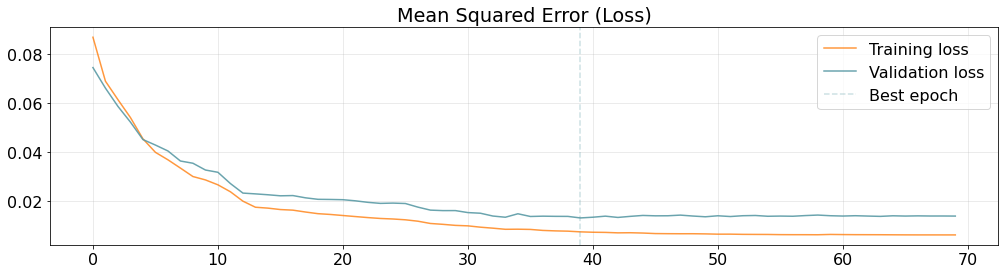

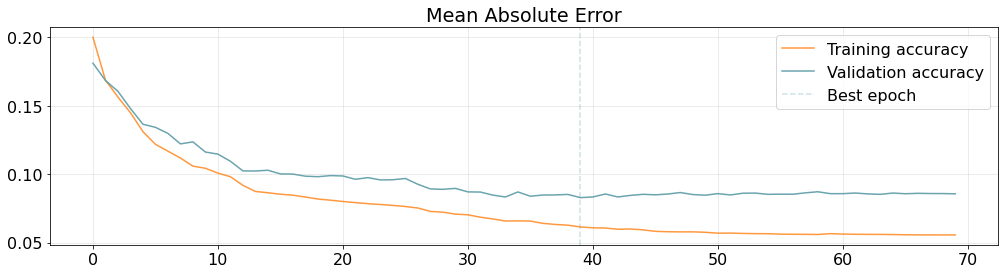

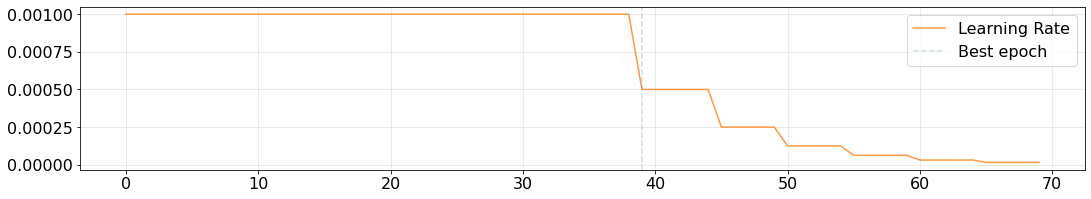

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['mae'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mae'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
#model.save('Models/'+title+'')
model = tfk.models.load_model('Models/'+title+'')

In [ ]:
# Predict the test set 
predictions = model.predict(X_test)
X_min = np.array([-0.972080, -8.450380, -34.802881, -9.028060, -1.275860, -6.006860, -38.816760])
X_max = np.array([15.106680, 18.122899, 41.138801, 14.035980, 6.056360, 77.371620, 31.024420])


predictions_full = predictions*(X_max-X_min)+X_min
y_full = y_test*(X_max-X_min)+X_min


mean_squared_error = tfk.metrics.mse(y_full.flatten(),predictions_full.flatten())
mean_absolute_error = tfk.metrics.mae(y_full.flatten(),predictions_full.flatten())
mean_squared_error, mean_absolute_error

(<tf.Tensor: shape=(), dtype=float64, numpy=45.84743840317878>,
 <tf.Tensor: shape=(), dtype=float64, numpy=4.013392658055142>)

In [ ]:
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

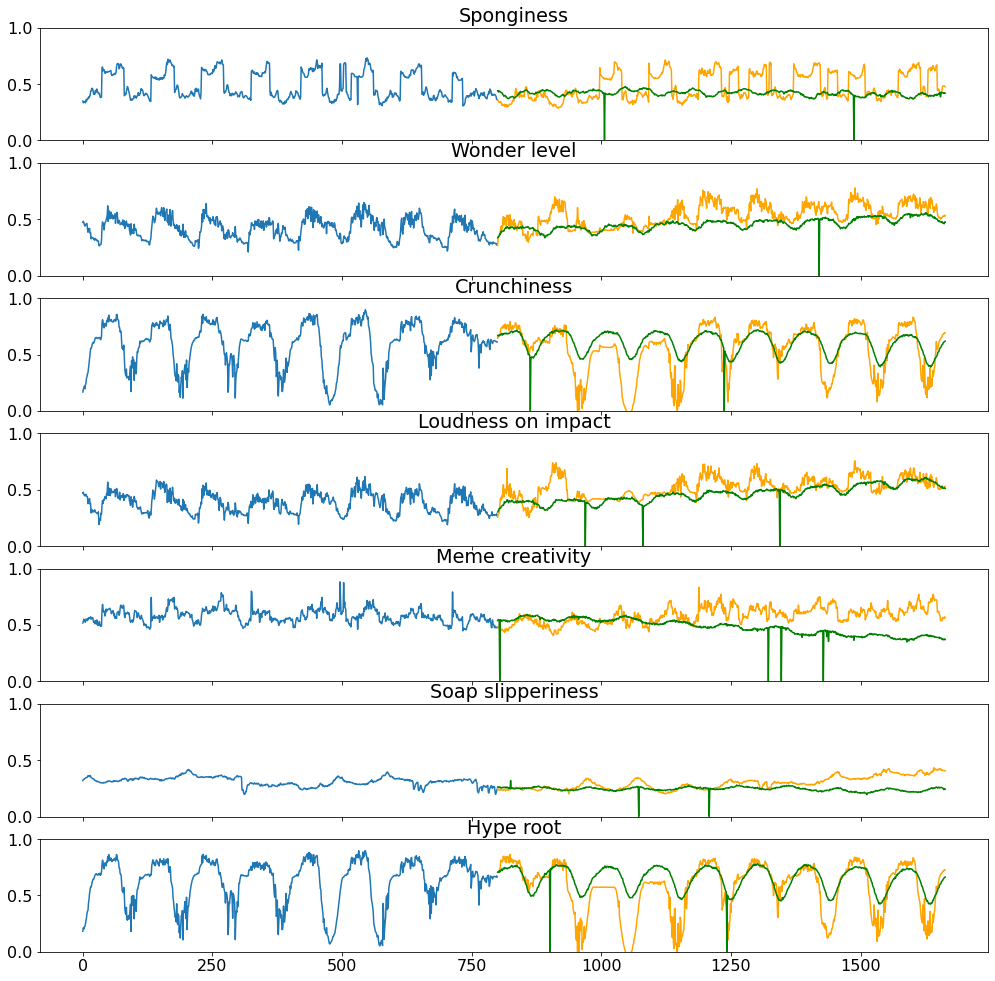

In [ ]:
inspect_multivariate_prediction(X_test, y_test, predictions, target_labels, telescope)